# Netflix EDA Project

This project will explore the Netflix Titles dataset to uncover insights and trends about the types of content available, country-wise production, year-wise additions, and more.

Both **pandas** and **SQL (SQLite)** are used for data analysis, and visualizations using **Matplotlib** and **Seaborn**.

**Source:** (https://www.kaggle.com/datasets/shivamb/netflix-shows)


## Step 1: Clean the Data

**Set Up:**

In [82]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
sns.set_palette("pastel")

**Read the dataset:**

In [83]:
df = pd.read_csv('../data/raw_netflix_titles.csv')

**Check the properties:**

In [84]:
print(df.shape)
df.info()
df.head()
df.tail()
df.dtypes
df.isnull().sum().sort_values(ascending=False)
df.duplicated().sum()
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")

(8807, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB
show_id: 8807 unique values
type: 2 unique values
title: 8807 unique values
director: 4528 unique values
cast: 7692 unique values
country: 748 unique values
date_added: 1767 unique values
release_year: 74 unique values
rating: 17 unique valu

**Findings:**

Raw netflix titles dataset contains 12 columns and 8807 rows.

Dataset contains 11 object colums and 1 integer column.

Columns director, cast, country, date_added, rating and duration has missing values.

Show_id and title has all unique data so there are no duplicates.

Column durations has a mixed format.

Date_added has string values and should be converted to a datetime object.


**Clean the data:**

In [85]:
df['director'] = df['director'].fillna('Unknown')
df['cast'] = df['cast'].fillna('Unknown')
df['country'] = df['country'].fillna('Unknown')
df['rating'] = df['rating'].fillna('Unknown')
df['duration'] = df['duration'].fillna('Unknown')

df['date_added'] = pd.to_datetime(
    df['date_added'].astype(str).str.strip(),
    format='mixed',
    errors='coerce'
)

df['duration_int'] = df['duration'].str.extract(r'(\d+)').astype(float)
df['duration_type'] = df['duration'].str.extract(r'([a-zA-Z]+)')

df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month

df = df.dropna(subset=['year_added']).copy()
df['year_added'] = df['year_added'].astype(int)

cols_to_clean = ['type', 'rating', 'country', 'listed_in']
for col in cols_to_clean:
    df[col] = df[col].str.strip()

**Save the clean data:**

In [86]:
df.to_csv('../data/cleaned_netflix_titles.csv', index=False)

## Step 2: Create a Database

**Create a DB for data analysis and exploration:**

In [87]:
df = pd.read_csv('../data/cleaned_netflix_titles.csv')
conn = sqlite3.connect('../data/netflix.db')
df.to_sql('netflix', conn, if_exists='replace', index=False)

8797

## Step 3: Explotary Analysis

**3.0: Check the properties of the cleaned data**

In [88]:
df = pd.read_sql('SELECT * FROM netflix', conn)
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8797 entries, 0 to 8796
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   show_id        8797 non-null   object 
 1   type           8797 non-null   object 
 2   title          8797 non-null   object 
 3   director       8797 non-null   object 
 4   cast           8797 non-null   object 
 5   country        8797 non-null   object 
 6   date_added     8797 non-null   object 
 7   release_year   8797 non-null   int64  
 8   rating         8797 non-null   object 
 9   duration       8797 non-null   object 
 10  listed_in      8797 non-null   object 
 11  description    8797 non-null   object 
 12  duration_int   8794 non-null   float64
 13  duration_type  8797 non-null   object 
 14  year_added     8797 non-null   int64  
 15  month_added    8797 non-null   float64
dtypes: float64(2), int64(2), object(12)
memory usage: 1.1+ MB


,release_year,duration_int,year_added,month_added
count,8797.000000,8794.000000,8797.000000,8797.000000
mean,2014.183472,69.920173,2018.871888,6.654996
std,8.822191,50.797005,1.574243,3.436554
min,1925.000000,1.000000,2008.000000,1.000000
25%,2013.000000,2.000000,2018.000000,4.000000
50%,2017.000000,88.000000,2019.000000,7.000000
75%,2019.000000,106.000000,2020.000000,10.000000
max,2021.000000,312.000000,2021.000000,12.000000


**3.1: Movies vs TV Shows**

Analyze the distribution of the content types on Netflix.

**SQL Query:**

In [89]:
query = '''
SELECT type, COUNT(*) as count
FROM netflix
GROUP By type
'''

df_type = pd.read_sql(query, conn)

**Visualization:**

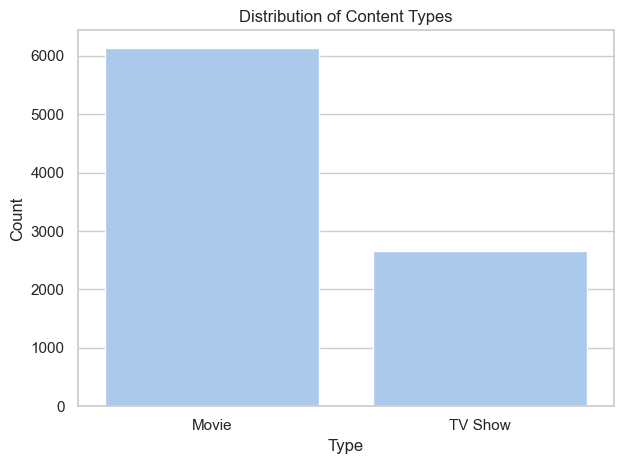

In [90]:
sns.barplot(data=df_type, x='type', y='count')
plt.title('Distribution of Content Types')
plt.xlabel('Type')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig("../visuals/content_type_distribution.png")
plt.show()

**3.2: The Growth of Netflix Content Over the Years**

Analyze the number of movies and TV series added to Netflix each year.

**SQL Query:**

In [91]:
query = '''
SELECT year_added, COUNT(*) as title_count
FROM netflix
WHERE year_added IS NOT NULL
GROUP BY year_added
ORDER BY year_added
'''

df_growth = pd.read_sql(query, conn)

**Visualization:**

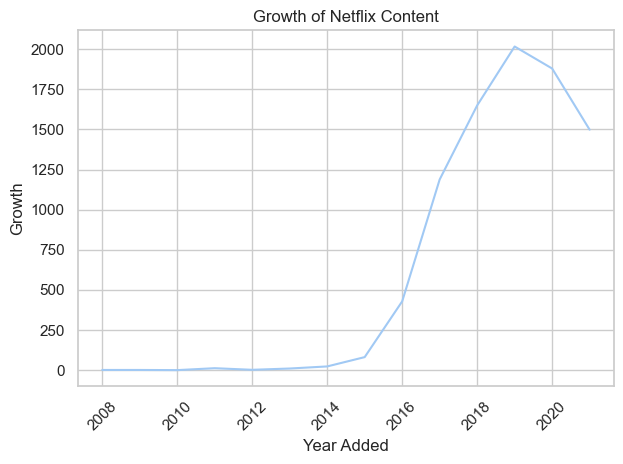

In [92]:
sns.lineplot(data=df_growth, x='year_added', y='title_count')
plt.title('Growth of Netflix Content')
plt.xlabel('Year Added')
plt.ylabel('Growth')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../visuals/content_growth.png")
plt.show()

**3.3: Most Common Genres**

Analyze the data set to find top 10 most common genres on Netflix.

**SQL Query:**

In [93]:
query = ''' 
SELECT show_id, listed_in
FROM netflix
'''

df_genres = pd.read_sql(query, conn)

**Clean and explode the genres:**

In [94]:
df_genres = df.copy()
df_genres['genre'] = df_genres['listed_in'].str.split(',')
df_genres = df_genres.explode('genre')
df_genres['genre'] = df_genres['genre'].str.strip()

genre_counts = df_genres['genre'].value_counts().head(10)

top_genres = genre_counts.reset_index()
top_genres.columns = ['genre', 'count']


**Visualization:**

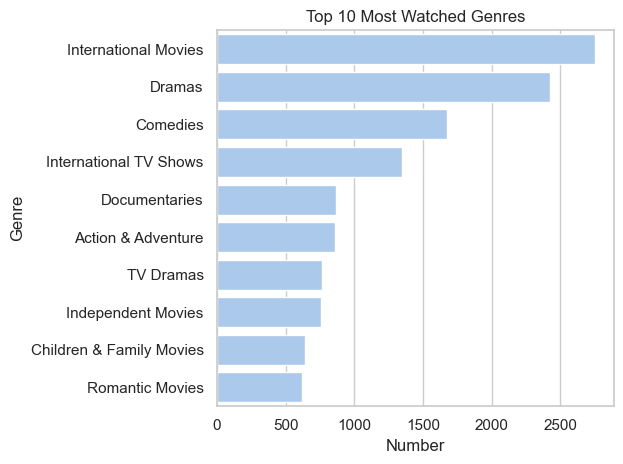

In [95]:
sns.barplot(data=top_genres, x='count', y='genre')
plt.title('Top 10 Most Watched Genres')
plt.xlabel('Number')
plt.ylabel('Genre')
plt.tight_layout()
plt.savefig("../visuals/top_genres.png")
plt.show()

**3.4: Top 5 Countries with the Most Content**

Analyze the number of contents that each country produced.

**SQL Query:**

In [96]:
query = ''' 
SELECT show_id, country
FROM netflix
WHERE country != 'Unknown'
'''

df_country = pd.read_sql(query,conn)

**Clean and explode the countries:**

In [97]:
df_country['country'] = df_country['country'].str.split(',')
df_country = df_country.explode('country')
df_country['country'] = df_country['country'].str.strip()

df_country = df_country[df_country['country'].str.lower() != 'unknown']
country_counts = df_country['country'].value_counts().head(5)

top_countries = country_counts.reset_index()
top_countries.columns = ['country', 'count']

**Visualization:**

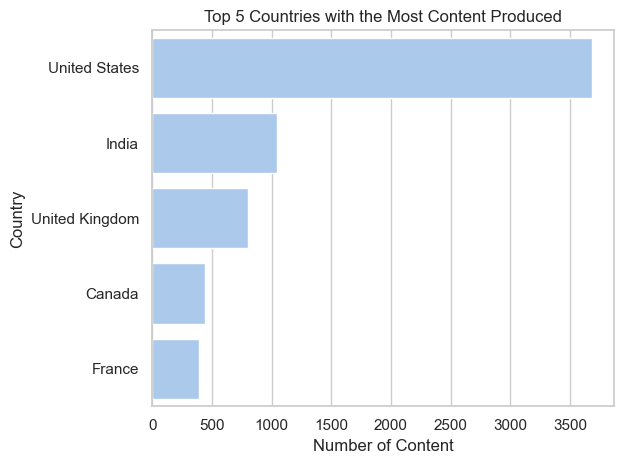

In [98]:
sns.barplot(data=top_countries, x='count', y='country')
plt.title('Top 5 Countries with the Most Content Produced')
plt.xlabel('Number of Content')
plt.ylabel('Country')
plt.tight_layout()
plt.savefig("../visuals/top_countries.png")
plt.show()

**3.5: Top Directors with the Most Content**

Analyze the number of directors on Netflix.

**SQL Query:**

In [99]:
query = ''' 
SELECT director, COUNT(*) as count
FROM netflix
WHERE director IS NOT NULL AND director != 'Unknown'
GROUP BY director
ORDER BY count DESC
LIMIT 10
'''

df_director = pd.read_sql(query, conn)
print(df_director)

                 director  count
0           Rajiv Chilaka     19
1  Raúl Campos, Jan Suter     18
2             Suhas Kadav     16
3            Marcus Raboy     16
4               Jay Karas     14
5     Cathy Garcia-Molina     13
6         Youssef Chahine     12
7         Martin Scorsese     12
8             Jay Chapman     12
9        Steven Spielberg     11


**This task does not require additional cleaning, exploding or visualization.**

**3.6: Average-Minimum-Maximum Durations of Movies**

Analayze the durations to find the average movie duration for the movie types.

**SQL Query:**

In [100]:
query = ''' 
SELECT 
    AVG(duration_int) as avg_duration,
    MIN(duration_int) as lowest_duration,
    MAX(duration_int) as highest_duration
FROM netflix
WHERE type = 'Movie' AND duration_type = 'min' AND duration_int IS NOT NULL
'''

df_duration = pd.read_sql(query, conn)

**Visualization:**

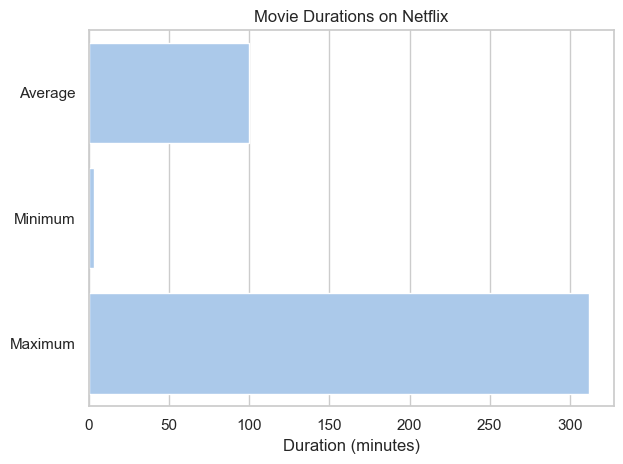

In [101]:
avg = df_duration['avg_duration'][0]
min_dur = df_duration['lowest_duration'][0]
max_dur = df_duration['highest_duration'][0]

stats = {'Average': avg, 'Minimum': min_dur, 'Maximum': max_dur}
labels = list(stats.keys())
values = list(stats.values())

sns.barplot(x=values, y=labels)
plt.title('Movie Durations on Netflix')
plt.xlabel('Duration (minutes)')
plt.tight_layout()
plt.savefig('../visuals/movie_duration.png')
plt.show()

**3.7: Distribution of Release Years**

Analayze how many titles were released each year.

**SQL Query:**

In [102]:
query = '''
SELECT release_year
FROM netflix
WHERE release_year IS NOT NULL
'''

df_release = pd.read_sql(query, conn)

**Visualization:**

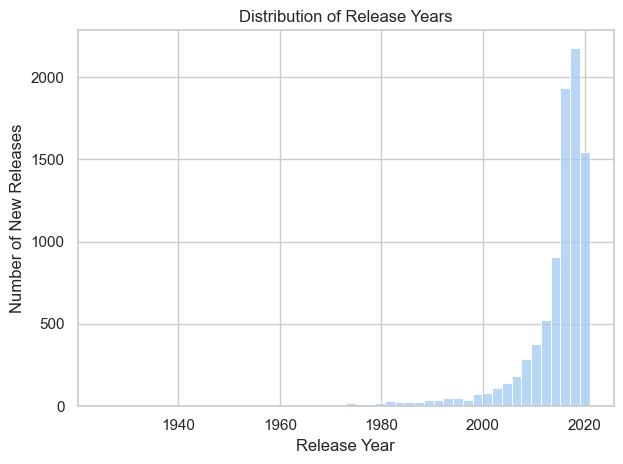

In [103]:
sns.histplot(data=df_release, x='release_year', bins=50)

plt.title('Distribution of Release Years')
plt.xlabel('Release Year')
plt.ylabel('Number of New Releases')
plt.tight_layout()
plt.savefig('../visuals/release_year_distribution.png')
plt.show()

**3.8: How Much of the Netflix Content is Produced in the US**

Analyze how many movies and tv shows include 'United States' in it's country and what's it portion against the other country's content.

**SQL Query:**

In [104]:
query = ''' 
SELECT 
    CASE
        WHEN country LIKE '%United States%' THEN 'US'
        ELSE 'Other'
    END AS origin_type,
    COUNT(*) as count
FROM netflix
GROUP BY origin_type
'''

df_origin = pd.read_sql(query, conn)

**Visualization:**

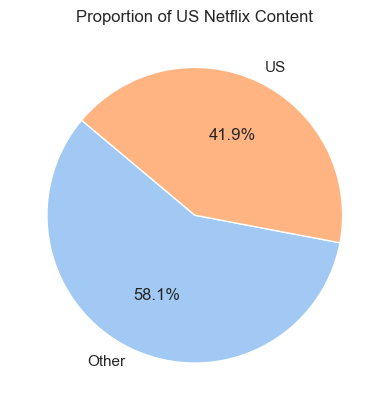

In [105]:
plt.pie(df_origin['count'], labels=df_origin['origin_type'], autopct='%1.1f%%', startangle=140)
plt.title('Proportion of US Netflix Content')
plt.savefig('../visuals/original_content.png')
plt.show()

**3.9: Content Distribution of Movies and TV Shows**

Analyze the ratings of movies and TV shows and compare.

**SQL Query:**

In [106]:
query = ''' 
SELECT 
    type,
    rating,
    COUNT(*) as count
FROM netflix
WHERE rating IS NOT NULL
GROUP BY type, rating
ORDER BY type, count DESC
'''

df_rating = pd.read_sql(query, conn)

**Visualization:**

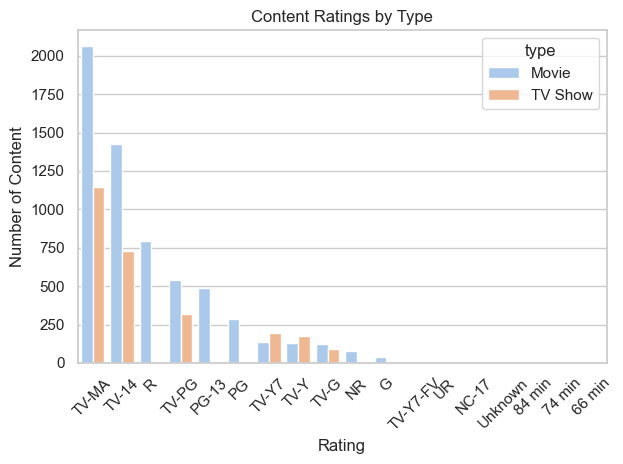

In [107]:
sns.barplot(data=df_rating, x='rating', y='count', hue='type')
plt.title('Content Ratings by Type')
plt.xlabel('Rating')
plt.ylabel('Number of Content')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../visuals/rating_type.png')
plt.show()

**3.10: Most Used Words in Movie Titles**

Analyze all the movie titles and find the most used words in the titles. I will use WorldCloud library to generate the image.

**SQL Query:**

In [108]:
query = ''' 
SELECT title
FROM netflix
WHERE type = 'Movie' AND title IS NOT NULL
'''

df_words = pd.read_sql(query, conn)

**Visualization:**

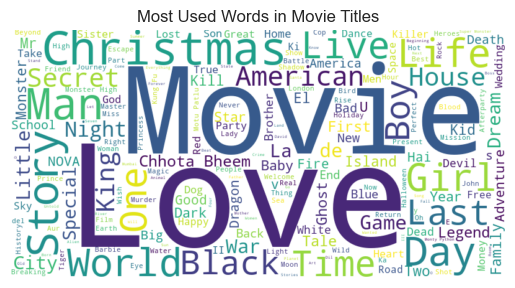

In [61]:
from wordcloud import WordCloud

text = ' '.join(df_words['title'].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Used Words in Movie Titles')
plt.savefig('../visuals/title_wordcloud.png')
plt.show()

### Explatory analysis done!!!

**Close the connection to the database:**

In [109]:
conn.close()

## Step 4: Findings

**3.1: Movies VS TV Shows**
- Movie content on Netflix is twice as large as TV Show content on Netflix.

**3.2: Growth of the Netflix Content Over the Years**
- Between 2008 and 2014, there was no to minimal content available on Netflix.
- Between 2014 and 2019, content grows extremely fast and has its peak in 2019.
- Between 2019 and 2021, number of content available decreases.

**3.3: Most Common Genres**
- International movies, dramas and comedies are the top 3 common genres on Netflix.

**3.4: Top 5 Countries with Most Content**
- In order: US, India, Uk, Canada, France are the top 5 countries with most content created.

**3.5: Top 10 Directors with Most Content**
- No visual was created for this task, only a simple table.
                 director  count
0           Rajiv Chilaka     19
1  Raúl Campos, Jan Suter     18
2             Suhas Kadav     16
3            Marcus Raboy     16
4               Jay Karas     14
5     Cathy Garcia-Molina     13
6         Youssef Chahine     12
7         Martin Scorsese     12
8             Jay Chapman     12
9        Steven Spielberg     11

**3.6: Average-Minimum-Maximum Duration of Movies**
- Average duration is 100 minutes.
- Minimum duration is 5 to 10 minutes.
- Maximum duratin is approxamately 350 minutes.

**3.7: Distribution of Release Years**
- Between 1970-2000 there are minimal releases.
- After 2000, up to 2019, releases increase gradually and has its peak at 2019.
- In 2020, there is a slight fall on releases.

**3.8: How Much of the Netflix Content is Produced in the US**
- 41.9% of the content was produced in the US.
- The remaining 58.1% was produced in the pther countries.

**3.9: Content Distribution of Movies and TV Shows**
- TV-MA and TV-14 dominates the content distribution of both movies and tv shows.
- There are no R, PG-13, PG, NR, G rated tv shows.
- Rest is pretty minimal and has close values for both movies and tv shows.

**3.10: Most Used Words in Movie Titles**
- The visualization for this task is rather not analysis friendly.
- However, it is possible to see that the words such as 'Love', 'Movie', 'Christmas', 'Story' generally dominates out of the tens and hundreds of words.
